# Import Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import Functions as fn
# Importing necessary functions from the custom module
from Functions import preprocess_dates, engineer_features, encode_categoricals, select_features, clip_outliers, scale_features
from Functions import run_pca, run_tsne, plot_elbow, cluster_and_profile, plot_profiles, plot_parallel_centroids, bootstrap_stability
from Functions import rfm_scores, plot_top_rfm_segments, plot_rfm_heatmap, plot_silhouette_vs_k, compute_silhouette

from collections import Counter

In [2]:
data = pd.read_csv('retail_data.csv')

In [ ]:
# use a fragment of data
data = data.sample(frac=0.01, random_state=42)


In [4]:
data.head()

,customer_id,age,gender,income_bracket,loyalty_program,membership_years,churned,marital_status,number_of_children,education_level,...,distance_to_store,holiday_season,season,weekend,customer_support_calls,email_subscriptions,app_usage,website_visits,social_media_engagement,days_since_last_purchase
987231,987232,60,Female,Medium,Yes,8,Yes,Divorced,3,Master's,...,76.72,Yes,Summer,Yes,1,Yes,Low,75,High,329
79954,79955,63,Other,Low,No,1,Yes,Single,0,High School,...,46.77,No,Winter,Yes,3,Yes,Medium,77,High,145
567130,567131,72,Other,Medium,Yes,0,No,Single,4,High School,...,31.77,Yes,Spring,Yes,14,Yes,Medium,52,Low,95
500891,500892,34,Other,High,Yes,3,No,Divorced,3,Master's,...,94.25,No,Summer,Yes,7,Yes,Low,21,Low,124
55399,55400,77,Other,Medium,No,3,No,Single,4,Master's,...,52.19,Yes,Spring,No,17,No,Low,69,Low,240


# EDA

Basic Structure

----------

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 987231 to 551383
Data columns (total 78 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                10000 non-null  int64  
 1   age                        10000 non-null  int64  
 2   gender                     10000 non-null  object 
 3   income_bracket             10000 non-null  object 
 4   loyalty_program            10000 non-null  object 
 5   membership_years           10000 non-null  int64  
 6   churned                    10000 non-null  object 
 7   marital_status             10000 non-null  object 
 8   number_of_children         10000 non-null  int64  
 9   education_level            10000 non-null  object 
 10  occupation                 10000 non-null  object 
 11  transaction_id             10000 non-null  int64  
 12  transaction_date           10000 non-null  object 
 13  product_id                 10000 non-null  in

16 floats + 24 int64 = 40 numericals

38 objects = non-numericals

78 columns, cover:

- Customer demographics(age, gender, income_bracket)

- Transactional data (transaction_id, quantity, unit_price, total_sales)

- Product information (product_category, rating, brand, stock)

- Promotional activities (promotion_type, promotion_effectiveness)

- behavioral metrics (avg_purchases_value, online_purchases, social_media_engagement)


In [6]:
data.describe()

,customer_id,age,membership_years,number_of_children,transaction_id,product_id,quantity,unit_price,discount_applied,transaction_hour,...,product_return_rate,product_weight,product_shelf_life,promotion_id,customer_zip_code,store_zip_code,distance_to_store,customer_support_calls,website_visits,days_since_last_purchase
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,498608.495300,48.426400,4.489700,1.998200,498359.896800,4973.22730,4.977700,503.125805,0.247524,11.509800,...,0.251084,5.021253,182.772900,506.186200,55343.935900,55075.438800,50.342749,9.434600,49.413200,181.676000
std,289724.824724,18.004238,2.851615,1.414849,288775.287879,2881.19938,2.588102,290.668343,0.144985,6.892725,...,0.144350,2.856312,105.311717,289.079409,26045.591534,25963.966001,28.962902,5.757885,28.878858,105.094232
min,79.000000,18.000000,0.000000,0.000000,11.000000,1.00000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.100000,0.000000,1.000000,10009.000000,10011.000000,0.040000,0.000000,0.000000,0.000000
25%,245730.250000,33.000000,2.000000,1.000000,250168.500000,2495.00000,3.000000,249.470000,0.120000,6.000000,...,0.130000,2.520000,92.000000,259.000000,32910.000000,32385.000000,25.467500,4.000000,24.000000,89.000000
50%,498226.500000,48.000000,5.000000,2.000000,496109.500000,4959.50000,5.000000,504.465000,0.250000,12.000000,...,0.250000,5.030000,183.000000,505.000000,54921.500000,55131.000000,50.565000,9.000000,50.000000,184.000000
75%,751040.000000,64.000000,7.000000,3.000000,750436.500000,7451.25000,7.000000,758.597500,0.370000,17.000000,...,0.380000,7.462500,275.000000,758.000000,78154.000000,77414.250000,75.342500,14.000000,74.000000,273.000000
max,999593.000000,79.000000,9.000000,4.000000,999868.000000,9998.00000,9.000000,999.990000,0.500000,23.000000,...,0.500000,10.000000,364.000000,999.000000,99998.000000,99979.000000,99.990000,19.000000,99.000000,364.000000


average_age: 54,2

average_qty: 5.266


In [7]:
pd.set_option('display.max_rows', None)
data.nunique().sort_values(ascending=True)

churned                          2
loyalty_program                  2
promotion_target_audience        2
weekend                          2
holiday_season                   2
email_subscriptions              2
marital_status                   3
income_bracket                   3
promotion_type                   3
promotion_channel                3
promotion_effectiveness          3
app_usage                        3
customer_state                   3
product_size                     3
product_brand                    3
gender                           3
social_media_engagement          3
store_state                      3
product_name                     4
customer_city                    4
purchase_frequency               4
education_level                  4
occupation                       4
store_city                       4
season                           4
product_material                 4
payment_method                   4
preferred_store                  4
store_location      

In [8]:
data.shape

(10000, 78)

In [9]:
data.isna().any()

customer_id                  False
age                          False
gender                       False
income_bracket               False
loyalty_program              False
membership_years             False
churned                      False
marital_status               False
number_of_children           False
education_level              False
occupation                   False
transaction_id               False
transaction_date             False
product_id                   False
product_category             False
quantity                     False
unit_price                   False
discount_applied             False
payment_method               False
store_location               False
transaction_hour             False
day_of_week                  False
week_of_year                 False
month_of_year                False
avg_purchase_value           False
purchase_frequency           False
last_purchase_date           False
avg_discount_used            False
preferred_store     

In [10]:
data.duplicated().sum()

np.int64(0)

----------

# Gender

In [11]:
data['gender'].value_counts()

gender
Female    3345
Other     3329
Male      3326
Name: count, dtype: int64

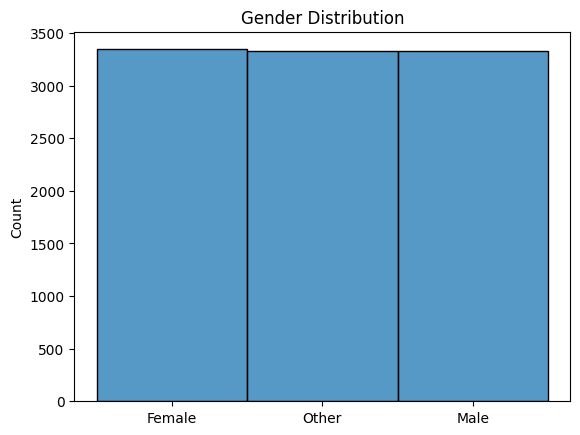

In [12]:
sns.histplot(data['gender'], bins=10)
plt.title('Gender Distribution')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

# Marital status

In [13]:
data['marital_status'].value_counts()

marital_status
Married     3390
Divorced    3314
Single      3296
Name: count, dtype: int64

In [14]:
data['marital_status'] = data['marital_status'].replace({'Divorced': 'Single'})

In [15]:
data['marital_status'].value_counts()

marital_status
Single     6610
Married    3390
Name: count, dtype: int64

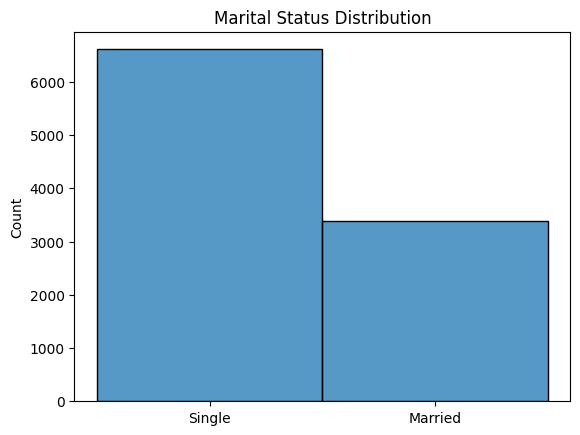

In [16]:
sns.histplot(data['marital_status'], bins=10)
plt.title('Marital Status Distribution')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

# Promotions

In [17]:
data['promotion_type'].value_counts()

promotion_type
Flash Sale              3341
20% Off                 3334
Buy One Get One Free    3325
Name: count, dtype: int64

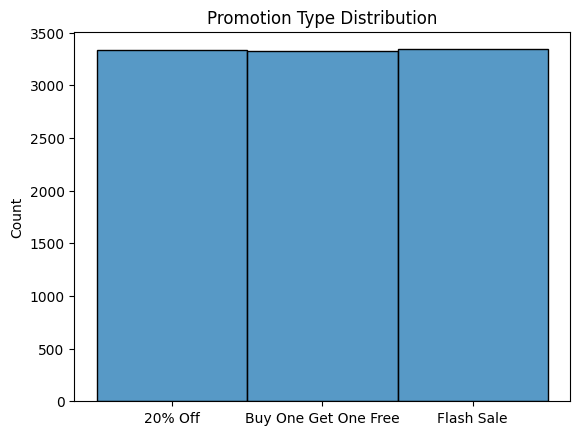

In [18]:
sns.histplot(data['promotion_type'], bins=10)
plt.title('Promotion Type Distribution')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

# Income bracket

In [19]:
data['income_bracket'].value_counts()

income_bracket
Medium    3385
Low       3362
High      3253
Name: count, dtype: int64

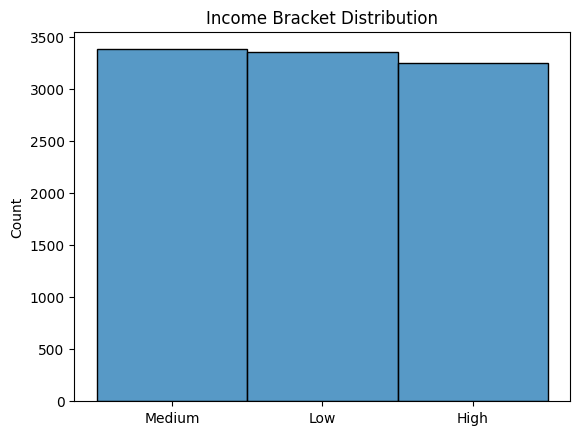

In [20]:
sns.histplot(data['income_bracket'], bins=10)
plt.title('Income Bracket Distribution')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

# Membership years

In [21]:
data['membership_years'].value_counts().sort_index()

membership_years
0     949
1    1051
2    1016
3     994
4     963
5    1043
6    1035
7     986
8    1014
9     949
Name: count, dtype: int64

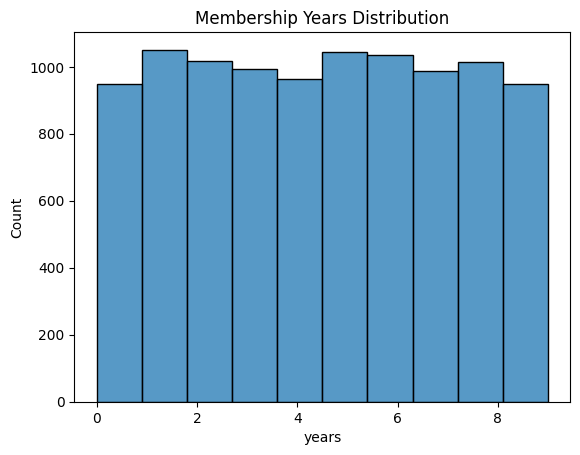

In [22]:
sns.histplot(data['membership_years'], bins=10)
plt.title('Membership Years Distribution')
plt.xlabel('years')
plt.ylabel('Count')
plt.show()

# Marital status vs promotions

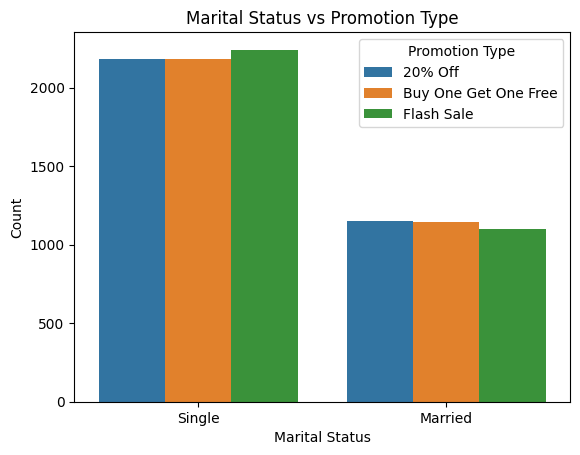

In [23]:
# marital_status vs promotion_type
sns.countplot(data=data, x='marital_status', hue='promotion_type')
plt.title('Marital Status vs Promotion Type')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Promotion Type')
plt.show()

# Purchase Frequency

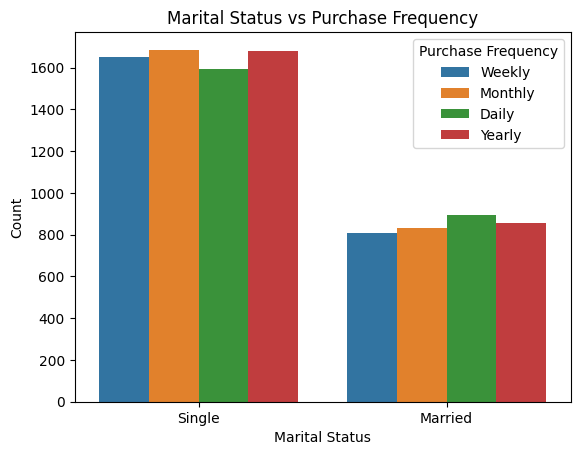

In [24]:
# marital_status vs purchase_frequency
sns.countplot(data=data, x='marital_status', hue='purchase_frequency')
plt.title('Marital Status vs Purchase Frequency')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Purchase Frequency')
plt.show()

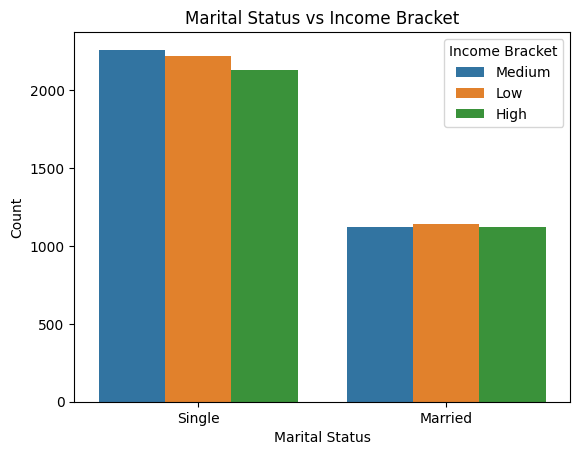

In [25]:
# marital_status vs income_bracket
sns.countplot(data=data, x='marital_status', hue='income_bracket')
plt.title('Marital Status vs Income Bracket')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Income Bracket')
plt.show()

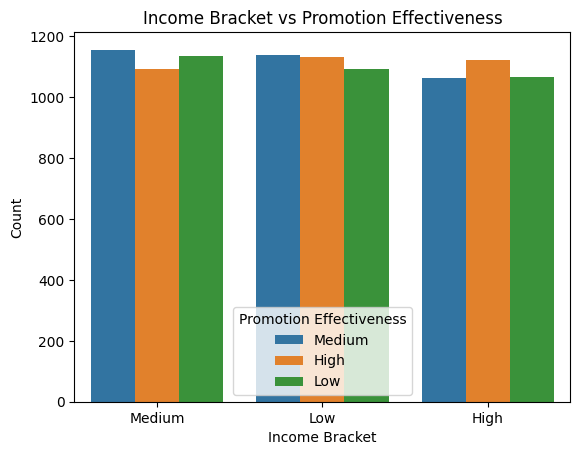

In [26]:
# income_bracket vs promotion_effectiveness
sns.countplot(data=data, x='income_bracket', hue='promotion_effectiveness')
plt.title('Income Bracket vs Promotion Effectiveness')
plt.xlabel('Income Bracket')
plt.ylabel('Count')
plt.legend(title='Promotion Effectiveness')
plt.show()

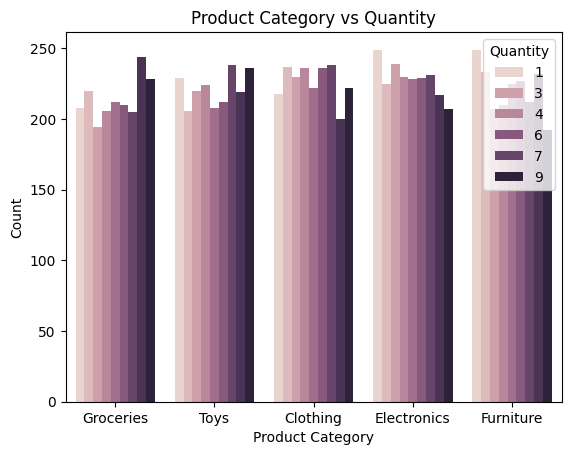

In [27]:
# product_category vs quantity
sns.countplot(data=data, x='product_category', hue='quantity')
plt.title('Product Category vs Quantity')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.legend(title='Quantity')
plt.show()

# Online vs in-store purchases

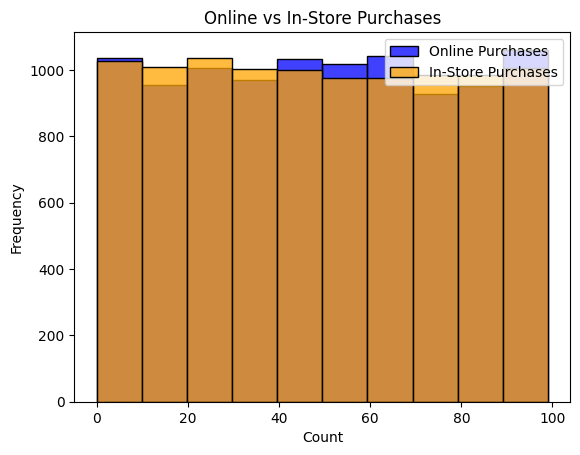

In [28]:
# online_purchases vs in_store_purchases histogram
sns.histplot(data['online_purchases'], bins=10, color='blue', label='Online Purchases')
sns.histplot(data['in_store_purchases'], bins=10, color='orange', label='In-Store Purchases')
plt.title('Online vs In-Store Purchases')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Total Sales

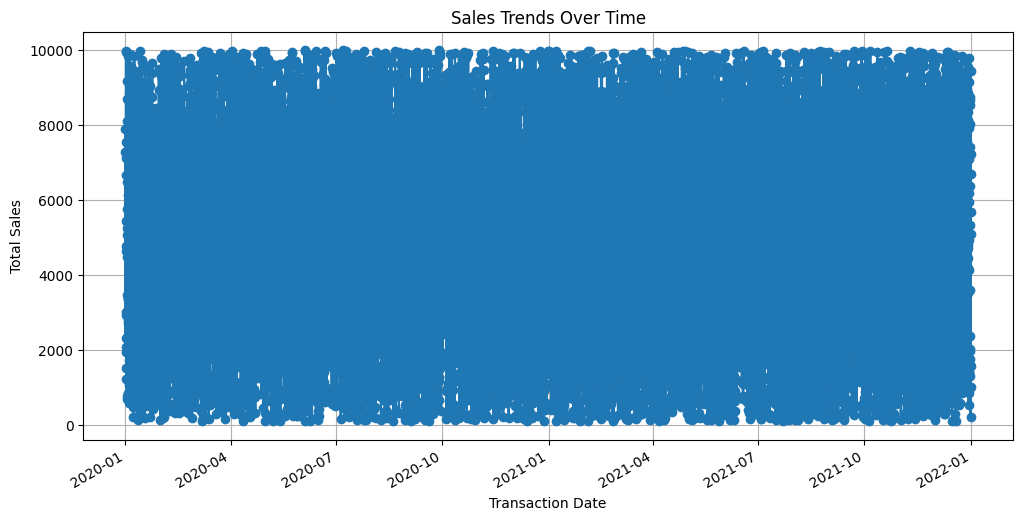

In [29]:
# Convert transaction_date to datetime if not already
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# Group by transaction_date and calculate total sales
sales_trends = data.groupby('transaction_date')['total_sales'].sum()

# Plot the sales trends
plt.figure(figsize=(12, 6))
sales_trends.plot(kind='line', marker='o')
plt.title('Sales Trends Over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()
 

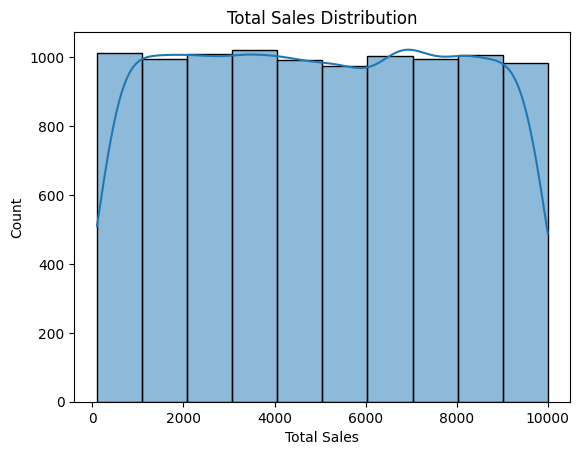

In [30]:
sns.histplot(data['total_sales'], bins=10, kde=True)
plt.title('Total Sales Distribution')
plt.xlabel('Total Sales')
plt.ylabel('Count')
plt.show()

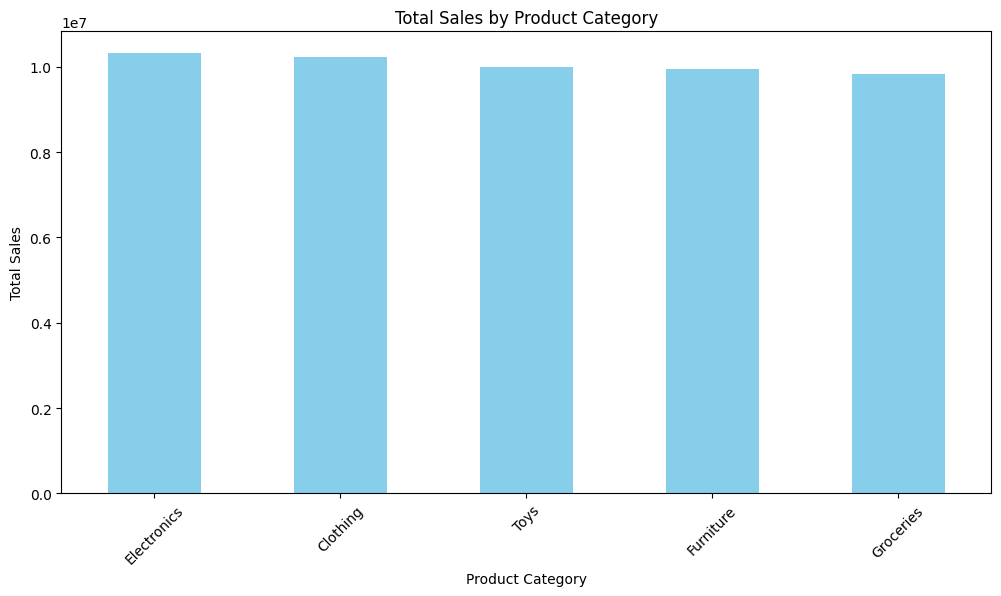

In [31]:
# total_sales by product_category
total_sales_by_category = data.groupby('product_category')['total_sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
total_sales_by_category.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


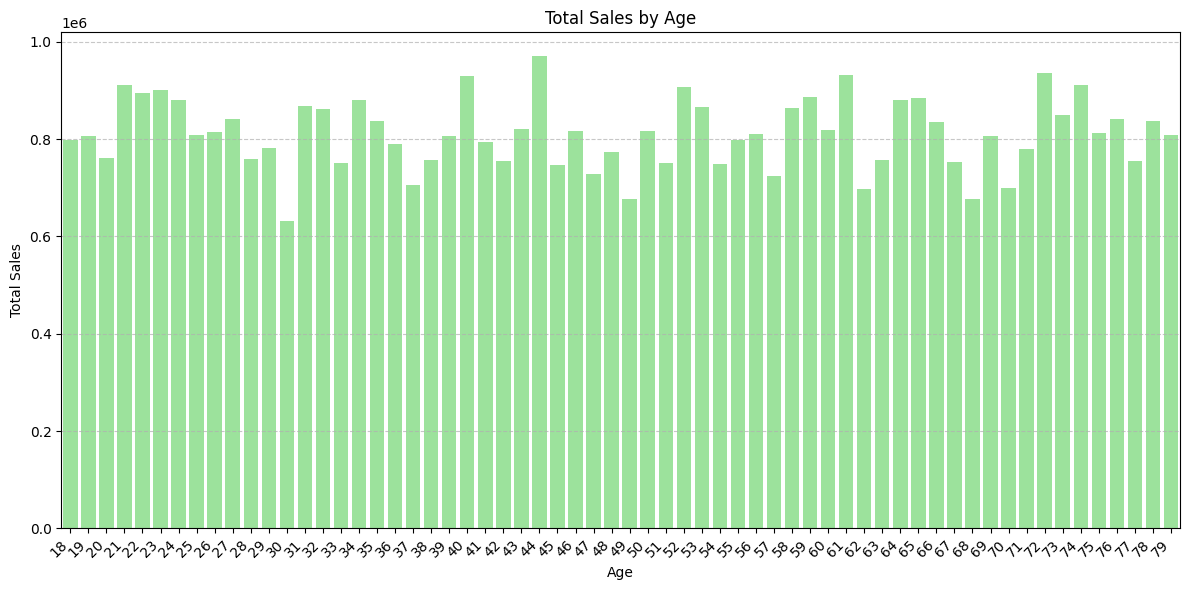

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

total_sales_by_age = data.groupby('age')['total_sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='age', y='total_sales', data=total_sales_by_age, color='lightgreen')

plt.title('Total Sales by Age')
plt.xlabel('Age')
plt.ylabel('Total Sales')

# Improve x-axis readability
plt.xticks(rotation=45, ha='right')   # Tilt labels 45 degrees, right-align
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: add light gridlines
plt.show()


# Churn

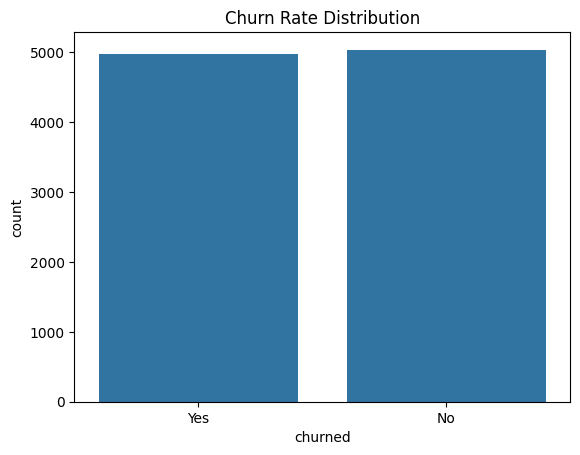

In [33]:
sns.countplot(x='churned', data=data)
plt.title('Churn Rate Distribution')
plt.show()

# Transaction Trends

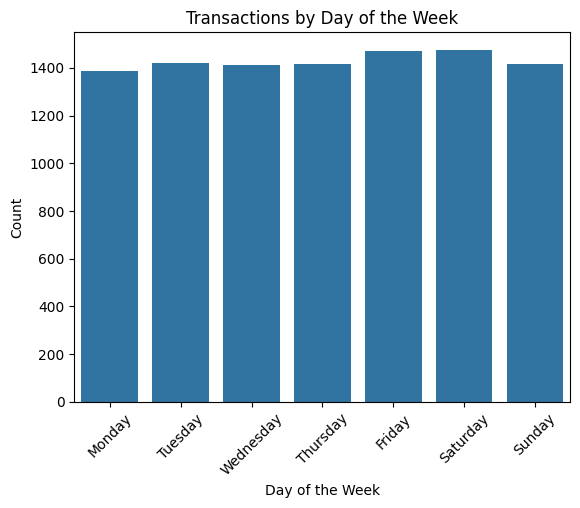

In [34]:
# Transactions by day of the week
data['transaction_day'] = data['transaction_date'].dt.day_name()
sns.countplot(data=data, x='transaction_day', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

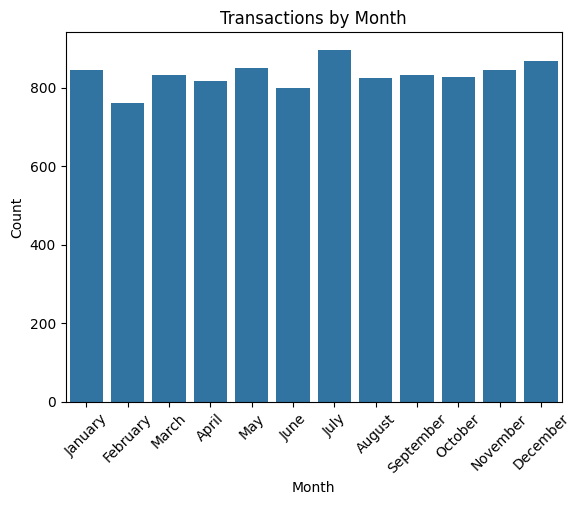

In [35]:
# Trabsactions by month
data['transaction_month'] = data['transaction_date'].dt.month_name()
sns.countplot(data=data, x='transaction_month', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Preprocessing & Feature Engineering

# Customer Lifetime Value analysis

PCA variance ratio: [0.23412648 0.18974007]


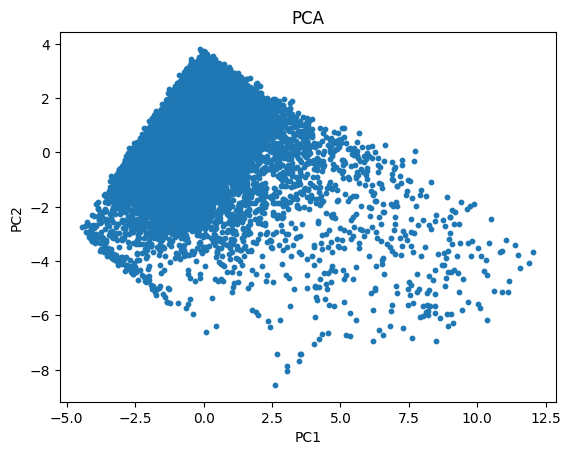

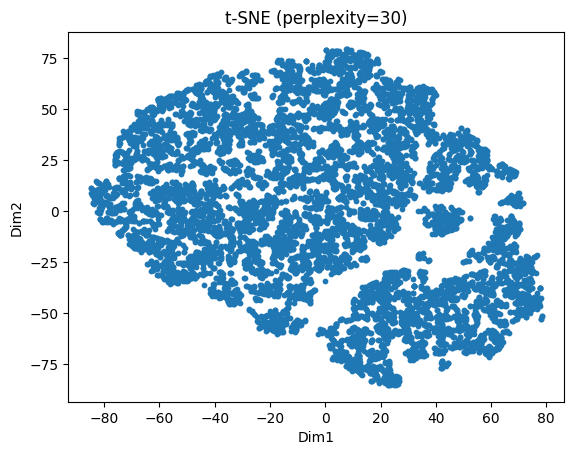

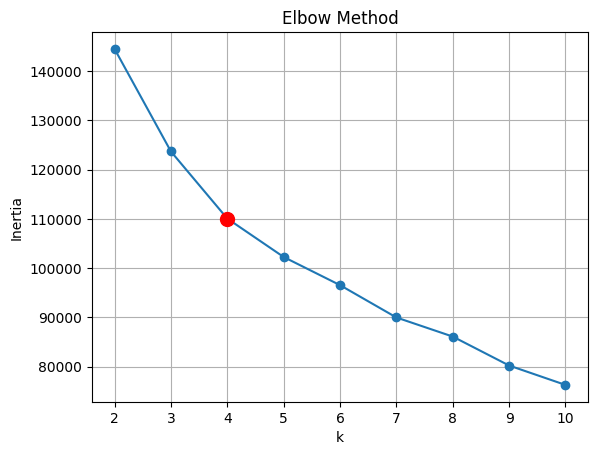

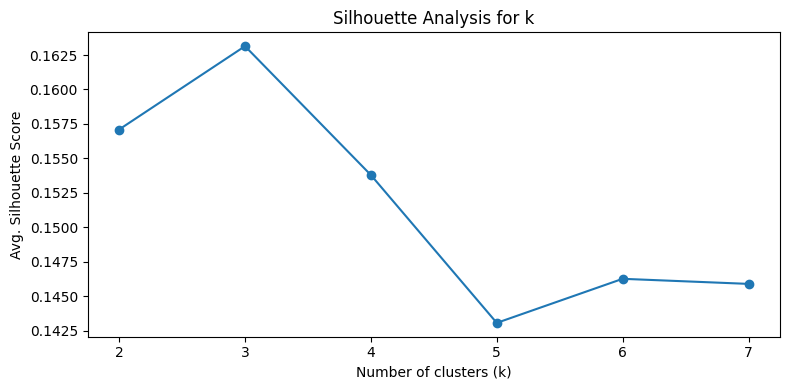

   cluster  count    net_sales  avg_order_value      clv_proxy  transactions  \
0        0   3113  5905.618050       181.117839   16636.682534     51.641825   
1        1    488  5596.559980      2200.677791  254265.525377      3.776639   
2        2   3305  1326.172242        42.671750    3973.526109     52.202421   
3        3   3094  6400.333323       194.485166   18039.892000     52.767615   

   recency_months     recency  frequency     monetary  rfm_score  \
0        2.626759   78.802763  51.641825  5905.618050  11.094764   
1        5.772951  173.188525   3.776639  5596.559980   7.655738   
2        6.474423  194.232678  52.202421  1326.172242   7.413011   
3        9.103555  273.106658  52.767615  6400.333323   8.822883   

  top_rfm_segment  
0             523  
1             115  
2             331  
3             245  


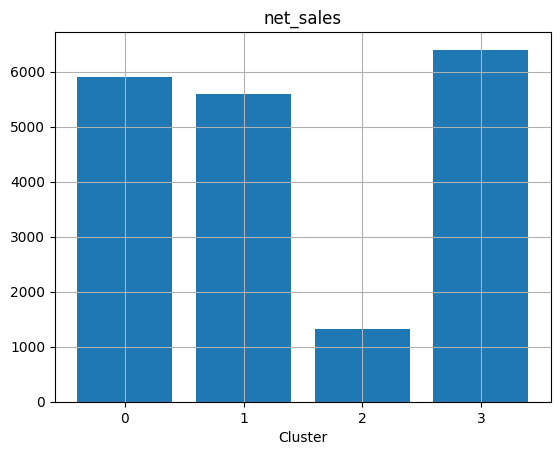

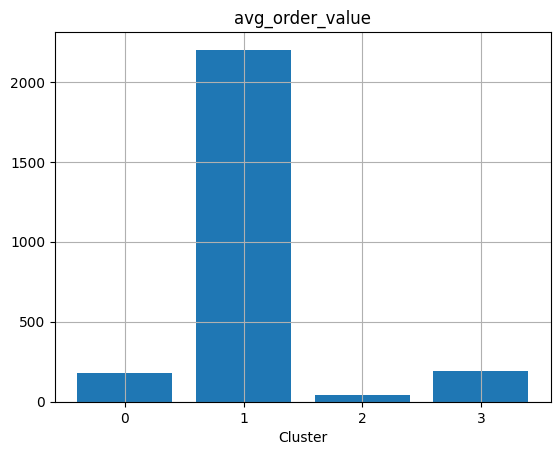

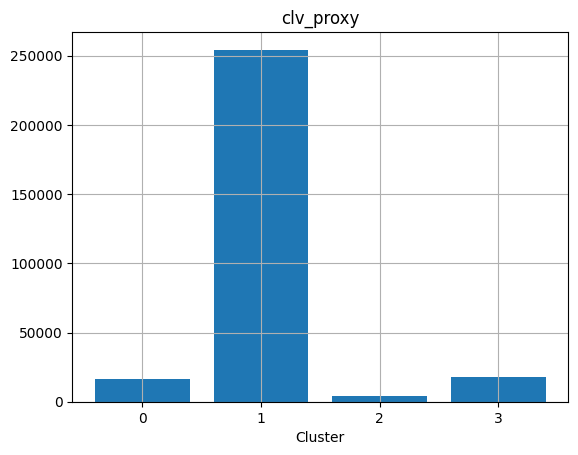

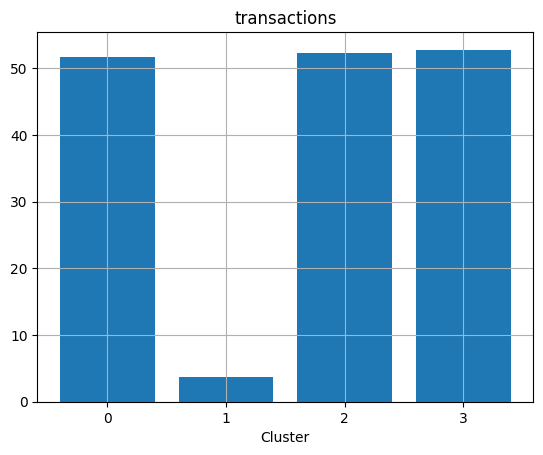

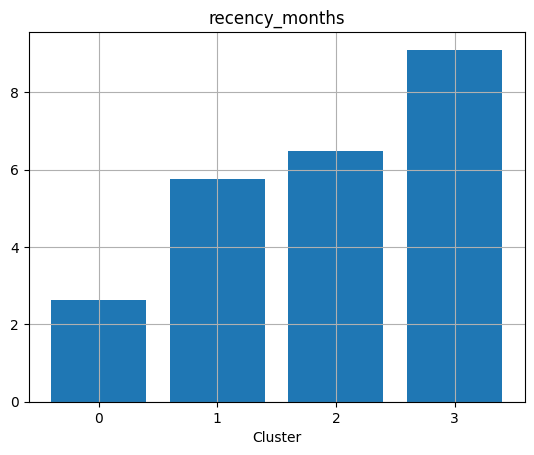

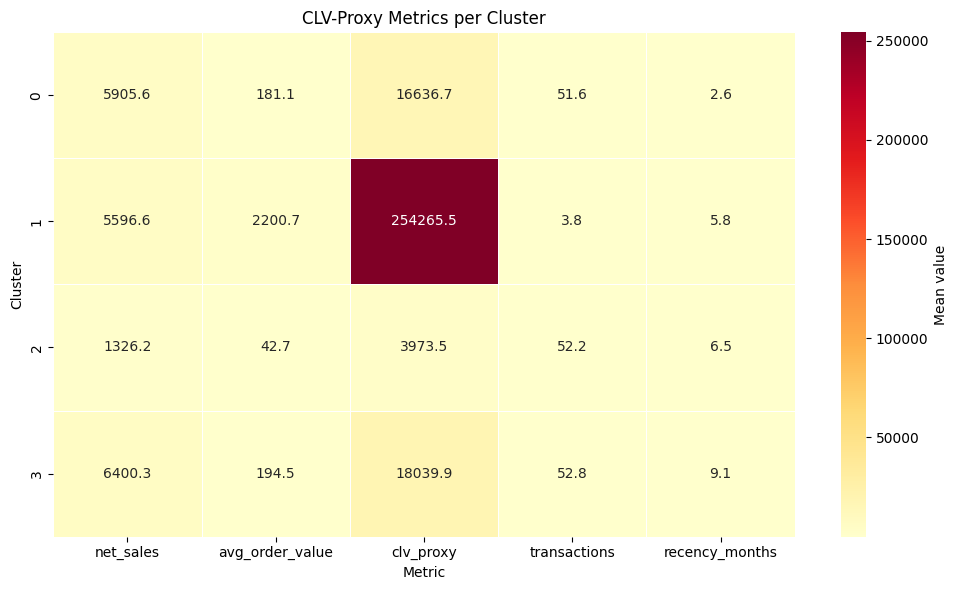

[Silhouette] Avg. score: 0.154


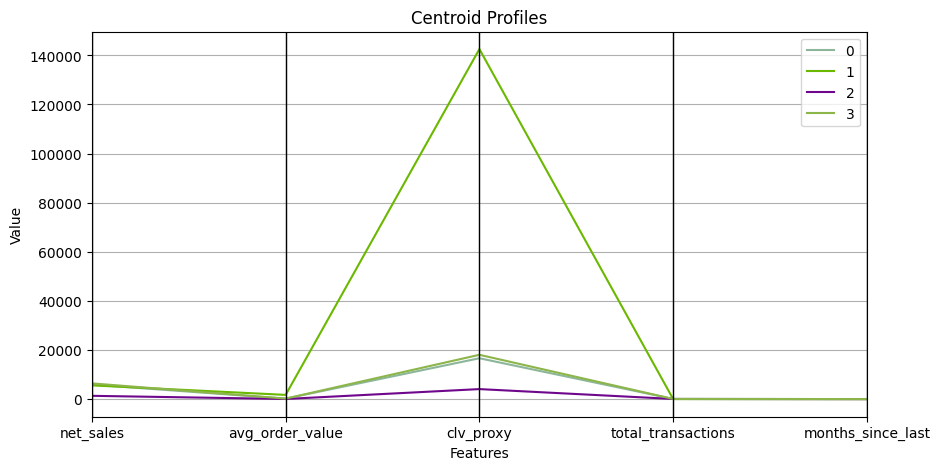

Mean ARI over 10 bootstraps: 0.963


In [ ]:
# --- Main Execution ---
if __name__ == '__main__':
    # Load DataFrame
    df = preprocess_dates(data)
    df = engineer_features(df)
    df = rfm_scores(df)
    df = encode_categoricals(df)
    features = select_features(df)

    num_cols = [c for c in features.select_dtypes('number') if c != 'customer_id']
    clipped = clip_outliers(features, num_cols)
    scaled = scale_features(clipped, num_cols)

    # Dimensionality Reduction
    _ = run_pca(scaled)
    _ = run_tsne(scaled)

    # Optimal k
    plot_elbow(scaled)

    # plot silhouette scores
    plot_silhouette_vs_k(scaled, range(2, 8))

    # Clustering
    labels, profile = cluster_and_profile(scaled, df, k=4)
    print(profile)
    plot_profiles(profile, ['net_sales','avg_order_value','clv_proxy','transactions','recency_months'])
    plot_clv_heatmap(profile)
    compute_silhouette(scaled, labels)

    # Centroid visualization
    centroid_feats = ['net_sales','avg_order_value','clv_proxy','total_transactions','months_since_last']
    plot_parallel_centroids(clipped.assign(cluster=labels), 'cluster', centroid_feats)

    # Stability
    _ = bootstrap_stability(scaled, labels)


# RFM Analysis

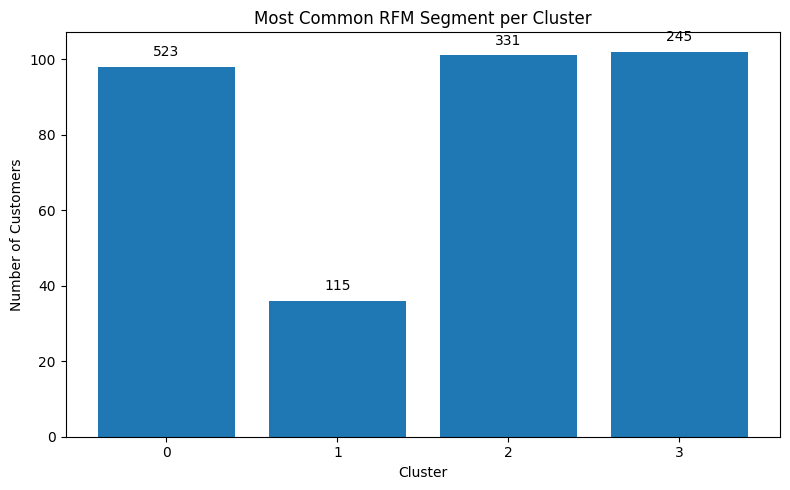

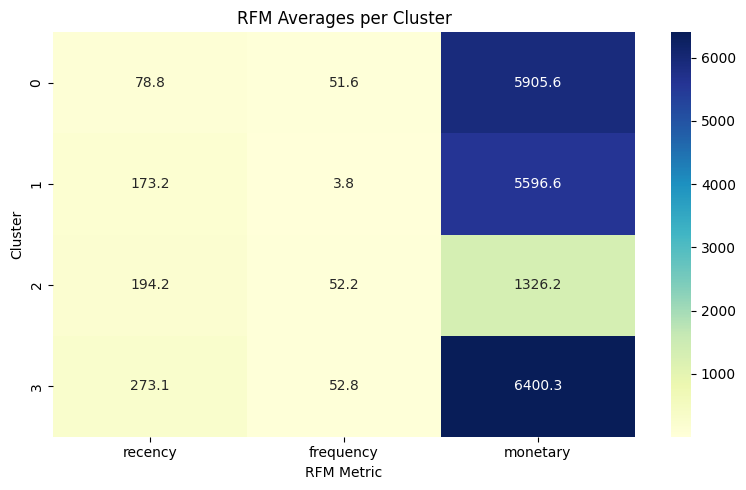

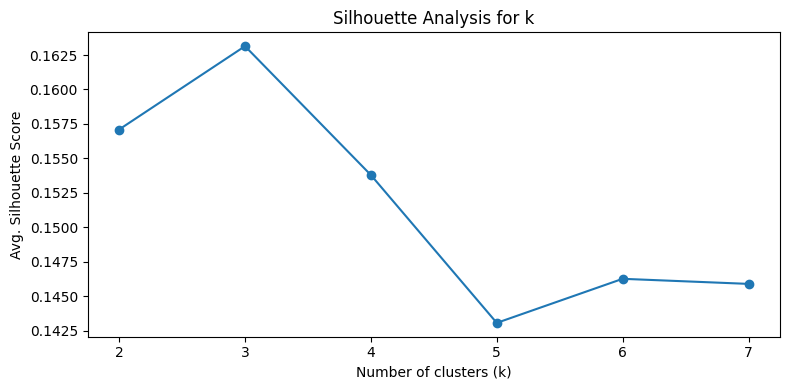

[Silhouette] Avg. score: 0.154
Cluster Profile Summary:
   cluster  count    net_sales  avg_order_value      clv_proxy  transactions  \
0        0   3113  5905.618050       181.117839   16636.682534     51.641825   
1        1    488  5596.559980      2200.677791  254265.525377      3.776639   
2        2   3305  1326.172242        42.671750    3973.526109     52.202421   
3        3   3094  6400.333323       194.485166   18039.892000     52.767615   

   recency_months     recency  frequency     monetary  rfm_score  \
0        2.626759   78.802763  51.641825  5905.618050  11.094764   
1        5.772951  173.188525   3.776639  5596.559980   7.655738   
2        6.474423  194.232678  52.202421  1326.172242   7.413011   
3        9.103555  273.106658  52.767615  6400.333323   8.822883   

  top_rfm_segment  
0             523  
1             115  
2             331  
3             245  
['cluster', 'count', 'net_sales', 'avg_order_value', 'clv_proxy', 'transactions', 'recency_months', 'r

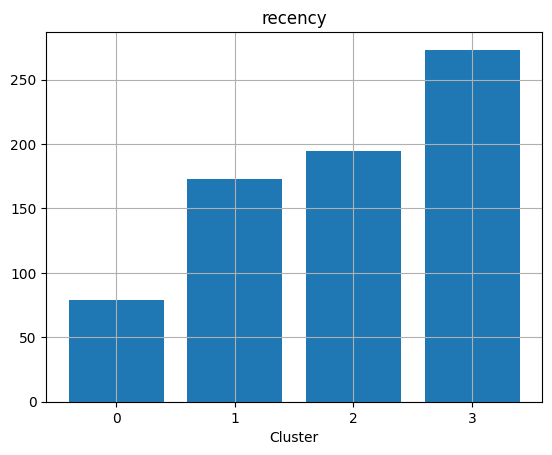

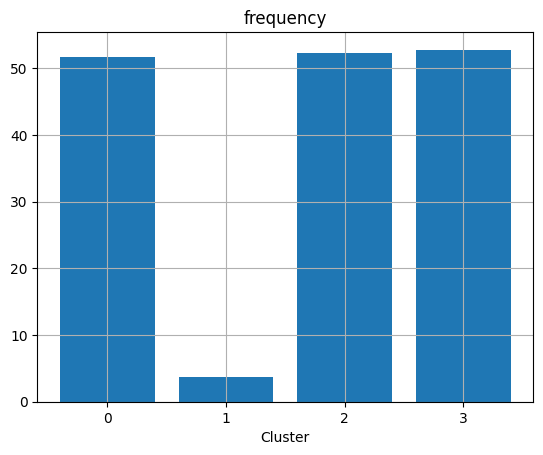

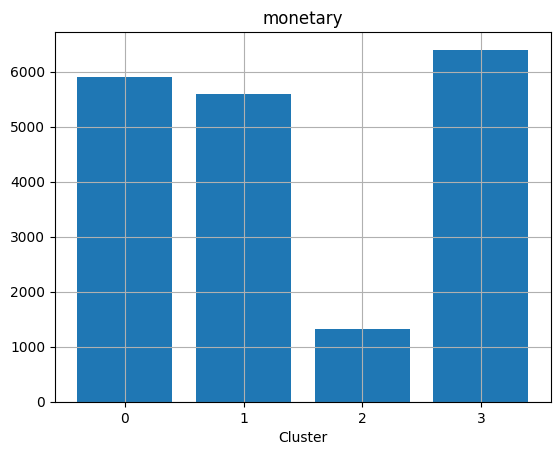

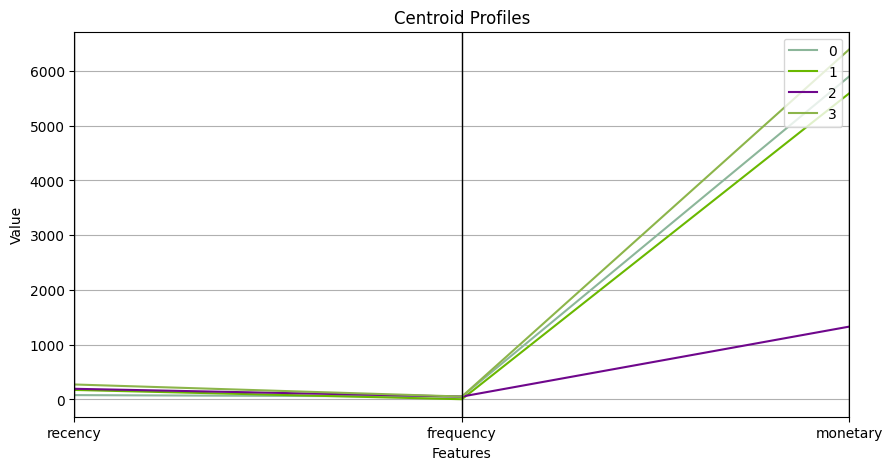

Mean ARI over 10 bootstraps: 0.962
Stability Results:
0.9619155361516298


In [ ]:
# --- Main Execution ---
if __name__ == '__main__':
   
    # Step 1: Preprocess & Engineer Features
    df = preprocess_dates(data)
    df = engineer_features(df)
    df = rfm_scores(df)

    # Step 2: Encode Categorical Variables and Selected Features
    df_encoded = encode_categoricals(df)
    df_selected = select_features(df_encoded)

    # Step 3: Clip Outliers
    num_cols = df_selected.select_dtypes(include='number').columns.drop('customer_id', errors='ignore')
    df_clipped = clip_outliers(df_selected, cols=num_cols.to_list())

    # Step 4: Scale Features
    df_scaled = scale_features(df_clipped, cols=num_cols.to_list())

    # Step 5: Clustering and Profiling (RFM enhanced)
    labels, profile = cluster_and_profile(df_scaled, df, k=4)
    plot_top_rfm_segments(df.assign(cluster=labels))
    plot_rfm_heatmap(profile)
    
    plot_silhouette_vs_k(df_scaled, range(2, 8))
    compute_silhouette(df_scaled, labels)

    # Step 6: Show results
    print("Cluster Profile Summary:")
    print(profile)
    print(profile.columns.to_list())
    
    # Plot Cluster Profiles
    plot_profiles(profile, ['recency', 'frequency', 'monetary'])
    plot_parallel_centroids(df_clipped.assign(cluster=labels), 'cluster', ['recency', 'frequency', 'monetary'])

    # Step 7: Stability Analysis
    stability_results = bootstrap_stability(df_scaled, labels)
    print("Stability Results:")
    print(stability_results)